# Bug 1796120: Comparing symbol files before and after introducing inline function data

[Bug 1796120](https://bugzilla.mozilla.org/show_bug.cgi?id=1796120) covers analyzing the change in symbol file sizes after we changed `dump_syms` to emit inline function data.

Socorro and Tecken are suffering multiple service degradations that are likely due to the increase in symbol file size from adding inline function information. The symbol file size for several modules has been going up generally anyhow, so even without the sudden jump from inline function information, symbol file sizes are rising and we probably need to adjust parts of how Socorro and Tecken work.

This notebook looks at sym file size across several axes:

* **compressed and uncompressed**

  Symbols files are compressed when stored in AWS S3. The compressed file size affects network transfer for uploading symbols to AWS S3 (Symbols upload) and downloading symbols from AWS S3 (Socorro processor download, Eliot symbolication download).
  
  Symbol files are uncompressed when they're in memory of processes that are using them and they're also uncompressed when cached on disk.
  
  We use [Symbolic](https://github.com/getsentry/symbolic) to parse symbol files in order to use them for lookups. The size of the resuling symcache object is also affected by the size of the symbol file.

* **for `XUL` (macOS), `xul.pdb` (Windows), and `libxul.so` (Linux) modules**

  These are the platform-specific modules for the library that is the largest part of the Firefox build. Inline function data differs across platforms because we use different compilers, the system calls are different, etc.

* **for a day in August 2022 and a day in October 2022**

  August 2022 is before we made the change to `dump_syms` to emit inline function data.
  
  October 2022 is well after we made the change to `dump_syms` to emit inline function data such that the bulk of uploaded symbol files include inline function data.

To get the files we want to look at, I downloaded the 100 symbol files each for `XUL`, `xul.pdb`, and `libxul.so` on August 20th, 2022 and October 22nd, 2022.

For each file, I captured:

* module
* debug id
* debug filename
* download url
* compressed size
* uncompressed size

I put that into csv files.

In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Analysis

<Figure size 640x480 with 0 Axes>

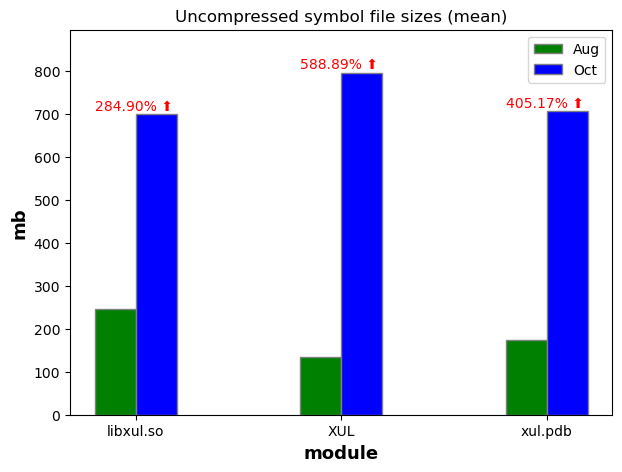

In [2]:
plt.figure()

libxul_2022_08 = pd.read_csv("./bug_1796120_data/2022_08_libxul.so.symdata.csv")
xul_2022_08 = pd.read_csv("./bug_1796120_data/2022_08_XUL.symdata.csv")
xulpdb_2022_08 = pd.read_csv("./bug_1796120_data/2022_08_xul.pdb.symdata.csv")

libxul_2022_10 = pd.read_csv("./bug_1796120_data/2022_10_libxul.so.symdata.csv")
xul_2022_10 = pd.read_csv("./bug_1796120_data/2022_10_XUL.symdata.csv")
xulpdb_2022_10 = pd.read_csv("./bug_1796120_data/2022_10_xul.pdb.symdata.csv")

# set width of bar
barWidth = 0.20
fig, ax = plt.subplots(figsize =(7, 5))

def to_mb(n):
    return int(n / 1_000_000)

# create bars
august_2022 = [
    to_mb(libxul_2022_08["size"].mean()),
    to_mb(xul_2022_08["size"].mean()),
    to_mb(xulpdb_2022_08["size"].mean()),
]
october_2022 = [
    to_mb(libxul_2022_10["size"].mean()),
    to_mb(xul_2022_10["size"].mean()),
    to_mb(xulpdb_2022_10["size"].mean()),
]
percent_increase = [
    float(october_item) / float(august_item) * 100
    for august_item, october_item in zip(august_2022, october_2022)
]

# set position of bar on X axis
br1 = np.arange(len(august_2022))
br2 = [x + barWidth for x in br1]

# generate plot
plt.bar(br1, august_2022, color ='g', width = barWidth, edgecolor ='grey', label ='Aug')
plt.bar(br2, october_2022, color ='b', width = barWidth, edgecolor ='grey', label ='Oct')

# add labels
plt.xlabel("module", fontweight="bold", fontsize = 13)
plt.ylabel("mb", fontweight="bold", fontsize = 13)
plt.xticks([r + (barWidth / 2) for r in range(len(august_2022))], ["libxul.so", "XUL", "xul.pdb"])
plt.ylim([0, max(august_2022 + october_2022) + 100])

# add percent increase
for i in range(len(august_2022)):
    plt.text(
        br1[i] - (barWidth / 2),
        october_2022[i] + 9,
        "%.2f%% ⬆️" % percent_increase[i],
        fontsize=10,
        color ="red",
    )

plt.title("Uncompressed symbol file sizes (mean)")
plt.legend()
plt.show()

The uncompressed sizes jumped significantly and by different amounts depending on the platform.

<Figure size 640x480 with 0 Axes>

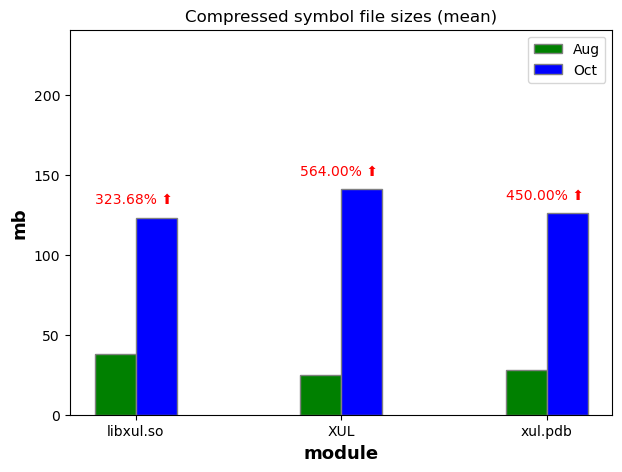

In [3]:
plt.figure()

libxul_2022_08 = pd.read_csv("./bug_1796120_data/2022_08_libxul.so.symdata.csv")
xul_2022_08 = pd.read_csv("./bug_1796120_data/2022_08_XUL.symdata.csv")
xulpdb_2022_08 = pd.read_csv("./bug_1796120_data/2022_08_xul.pdb.symdata.csv")

libxul_2022_10 = pd.read_csv("./bug_1796120_data/2022_10_libxul.so.symdata.csv")
xul_2022_10 = pd.read_csv("./bug_1796120_data/2022_10_XUL.symdata.csv")
xulpdb_2022_10 = pd.read_csv("./bug_1796120_data/2022_10_xul.pdb.symdata.csv")

# set width of bar
barWidth = 0.20
fig, ax = plt.subplots(figsize =(7, 5))

def to_mb(n):
    return int(n / 1_000_000)

# create bars
august_2022 = [
    to_mb(libxul_2022_08["compressed_size"].mean()),
    to_mb(xul_2022_08["compressed_size"].mean()),
    to_mb(xulpdb_2022_08["compressed_size"].mean()),
]
october_2022 = [
    to_mb(libxul_2022_10["compressed_size"].mean()),
    to_mb(xul_2022_10["compressed_size"].mean()),
    to_mb(xulpdb_2022_10["compressed_size"].mean()),
]
percent_increase = [
    float(october_item) / float(august_item) * 100
    for august_item, october_item in zip(august_2022, october_2022)
]

# set position of bar on X axis
br1 = np.arange(len(august_2022))
br2 = [x + barWidth for x in br1]

# generate plot
plt.bar(br1, august_2022, color ='g', width = barWidth, edgecolor ='grey', label ='Aug')
plt.bar(br2, october_2022, color ='b', width = barWidth, edgecolor ='grey', label ='Oct')

# add labels
plt.xlabel("module", fontweight="bold", fontsize = 13)
plt.ylabel("mb", fontweight="bold", fontsize = 13)
plt.xticks([r + (barWidth / 2) for r in range(len(august_2022))], ["libxul.so", "XUL", "xul.pdb"])
plt.ylim([0, max(august_2022 + october_2022) + 100])

# add percent increase
for i in range(len(august_2022)):
    plt.text(
        br1[i] - (barWidth / 2),
        october_2022[i] + 9,
        "%.2f%% ⬆️" % percent_increase[i],
        fontsize=10,
        color ="red",
    )

plt.title("Compressed symbol file sizes (mean)")
plt.legend()
plt.show()

The compressed sizes also jumped significantly and differently depending on platform.

# Conclusion

Symbol file sizes (mean) increased substantially.